#### Indicadores Línea de Cuidados PGD

In [187]:
rm(list=ls())

if(! require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr, httr, janitor, stringr, readxl, 
                writexl, tools, dplyr, foreign, ggplot2, openxlsx)

options(timeout = 900)

In [188]:
# URL del archivo ZIP de microdatos
url <- "https://www.inegi.org.mx/contenidos/programas/enut/2024/microdatos/enut_2024_bd_csv.zip"

# Archivo temporal donde se guarda el ZIP
destfile <- tempfile(fileext = ".zip")

download.file(url, destfile, mode = "wb", method = "libcurl") # Descargar

# Descomprimir y revisar archivos
unzip_dir <- tempdir()  # Carpeta temporal
unzip(destfile, exdir = unzip_dir)

# Cargar las bases necesarias UNA SOLA VEZ
personas    <- read_csv(file.path(unzip_dir, "tsdem.csv"), show_col_types = FALSE)
actividades <- read_csv(file.path(unzip_dir, "tmodulo.csv"), show_col_types = FALSE)
# hogares <- read_csv(file.path(unzip_dir, "thogar.csv"), show_col_types = FALSE)
# viviendas <- read_csv(file.path(unzip_dir, "tvivienda.csv"), show_col_types = FALSE)
varcrea     <- read_csv(file.path(unzip_dir, "tvar_crea.csv"), show_col_types = FALSE)

# Unión de las bases (USANDO 'actividades' y 'varcrea' para evitar la lectura redundante)
enut24 <- actividades %>%
  # El left_join se hace con el objeto 'varcrea' que ya está cargado
  left_join(varcrea, by = c('LLAVEMOD', 'LLAVEVIV', 'LLAVEHOG','SEXO', 'CVE_ENT', 'FAC_PER')) %>%

  # Aplicar las demás transformaciones
  clean_names() %>%
  mutate(across(everything(), as.numeric)) %>%
  filter(cve_ent == 9)

  message("Base ENUT 2024 (enut24) creada y filtrada para CDMX.")

Base ENUT 2024 (enut24) creada y filtrada para CDMX.



In [189]:
# Ver rango del factor de expansión
summary(enut24$fac_per)

# Número de registros y NA
length(enut24$fac_per)
sum(is.na(enut24$fac_per))

# Población cubierta por edad mínima
summary(enut24$edad)  # si tienes variable edad

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1040    3510    4004    3963    4408    7012 

[1] 2107

[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12.00   29.00   44.00   44.81   60.00   98.00 

#### Promedio de horas semanales que las mujeres en Ciudad de México dedican al cuidado de otros integrantes del hogar sin remuneración

In [190]:
## Categorías y sus variables que utilizaremos para identificar los trabajos de cuidado a otras personas

#Categoría 1: Cuidados directos no remunerados a personas con discapacidad o enfermedad
var_discap_enfer <- c('p6_16a_3_1', 'p6_16a_3_2', 'p6_16a_3_3', 'p6_16a_3_4')

#Categoría 2: Cuidados directos no remunerados a bebés, niñas o niños de 0 a 5 años
var_cuid_0_5 <- c('p6_16a_4_1', 'p6_16a_4_2', 'p6_16a_4_3', 'p6_16a_4_4')

#Categoría 3: Cuidados directos no remunerados a bebés, niñas o niños de personas de 6 a 59 años
var_cuid_6_59 <- c('p6_16a_5_1', 'p6_16a_5_2', 'p6_16a_5_3', 'p6_16a_5_4')

#Categoría 4: Cuidados directos no remunerados a personas de 60 años y más
var_cuid_60 <- c('p6_16a_6_1', 'p6_16a_6_2', 'p6_16a_6_3', 'p6_16a_6_4')

In [191]:
#Horas totales en la semana
tiempo_semana <- enut24  %>%
filter(p6_16_3 == 1 | p6_16_4 == 1 | p6_16_5 == 1 | p6_16_6 == 1) %>%
mutate(tiempo_discap  = (p6_16a_3_1 + p6_16a_3_2/60) + (p6_16a_3_3 + p6_16a_3_4/60),
    tiempo_0_5     = (p6_16a_4_1 + p6_16a_4_2/60) + (p6_16a_4_3 + p6_16a_4_4/60),
    tiempo_6_59    = (p6_16a_5_1 + p6_16a_5_2/60) + (p6_16a_5_3 + p6_16a_5_4/60),
    tiempo_60mas   = (p6_16a_6_1 + p6_16a_6_2/60) + (p6_16a_6_3 + p6_16a_6_4/60),
    tiempo_total = rowSums(across(c(tiempo_discap, tiempo_0_5, tiempo_6_59, tiempo_60mas)), na.rm = TRUE))
#group_by(sexo)

head(tiempo_semana)

llavemod,llaveviv,llavehog,sexo,edad_v,p4_1,p4_1c,niv_x,gra_x,p4_3,⋯,upm_dis_y,control_y,viv_sel_y,hogar_y,n_ren_y,tiempo_discap,tiempo_0_5,tiempo_6_59,tiempo_60mas,tiempo_total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
90002903101,90002903,900029031,1,46,2,NA,8,3,NA,⋯,1148,900029,3,1,1,NA,NA,1,NA,1
90018104102,90018104,900181041,2,69,2,NA,3,3,NA,⋯,1149,900181,4,1,2,NA,4,NA,NA,4
90018301101,90018301,900183011,2,53,2,NA,8,4,NA,⋯,1150,900183,1,1,1,3,NA,NA,NA,3
90018301103,90018301,900183011,2,51,2,NA,8,4,NA,⋯,1150,900183,1,1,3,3,NA,NA,NA,3
90027001101,90027001,900270011,1,71,2,NA,3,3,NA,⋯,1152,900270,1,1,1,5,NA,NA,NA,5
90027001102,90027001,900270011,2,68,2,NA,3,3,NA,⋯,1152,900270,1,1,2,4,NA,NA,NA,4


In [192]:
#Tiempo promedio en la semana
tiempo_prom_gen <- tiempo_semana %>%
filter(tiempo_total > 0) %>%
summarise(horas_prom_gen = weighted.mean(tiempo_total, fac_per, na.rm = TRUE)) %>%
pull(horas_prom_gen)

tiempo_prom_gen

[1] 9.967262

PROYECCIONES

In [193]:
# Paso 1: Definición de valores base
ano_base <- 2024 
valor_base <- tiempo_prom_gen # Valor promedio de horas en 2024

# Paso 2: Definición de Metas de Descenso para 2045 (Lógica Lineal)
# Queremos que las horas promedio de cuidado NO remunerado disminuyan.
# Estos factores son la meta de reducción final.
inercial_2045      <- valor_base * 0.90 # Reducción del 10%
deseable_2045      <- valor_base * 0.80 # Reducción del 20%
transformador_2045 <- valor_base * 0.70 # Reducción del 30%

# Paso 3: Construcción de la Serie de Proyección Anual
fut_years <- seq(ano_base, 2045, by = 1)
n_fut <- length(fut_years) # Número de puntos a proyectar (incluye año base)

df_proyeccion_horas <- data.frame(
  ciclo = fut_years,
  # Proyección lineal desde el valor_base hasta la meta de 2045
  Inercial = seq(valor_base, inercial_2045, length.out = n_fut),
  Deseable = seq(valor_base, deseable_2045, length.out = n_fut),
  Transformador = seq(valor_base, transformador_2045, length.out = n_fut)
)

In [194]:
# Paso 4: Redondeo
cols_to_round <- c("Inercial", "Deseable", "Transformador") 
df_proyeccion_horas[, cols_to_round] <- round(df_proyeccion_horas[, cols_to_round], 2)

# Crear los objetos para la visualización (solo la serie proyectada)
fut_horas <- df_proyeccion_horas

message("Dataframe de proyecciones anuales de Horas de Cuidado (solo año base):")
print(df_proyeccion_horas)
message("El objeto 'df_proyeccion_horas' y 'fut_horas' están listos para graficar.")

Dataframe de proyecciones anuales de Horas de Cuidado (solo año base):



   ciclo Inercial Deseable Transformador
1   2024     9.97     9.97          9.97
2   2025     9.92     9.87          9.82
3   2026     9.87     9.78          9.68
4   2027     9.82     9.68          9.54
5   2028     9.78     9.59          9.40
6   2029     9.73     9.49          9.26
7   2030     9.68     9.40          9.11
8   2031     9.64     9.30          8.97
9   2032     9.59     9.21          8.83
10  2033     9.54     9.11          8.69
11  2034     9.49     9.02          8.54
12  2035     9.45     8.92          8.40
13  2036     9.40     8.83          8.26
14  2037     9.35     8.73          8.12
15  2038     9.30     8.64          7.97
16  2039     9.26     8.54          7.83
17  2040     9.21     8.45          7.69
18  2041     9.16     8.35          7.55
19  2042     9.11     8.26          7.40
20  2043     9.07     8.16          7.26
21  2044     9.02     8.07          7.12
22  2045     8.97     7.97          6.98


El objeto 'df_proyeccion_horas' y 'fut_horas' están listos para graficar.



GRÁFICO

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"

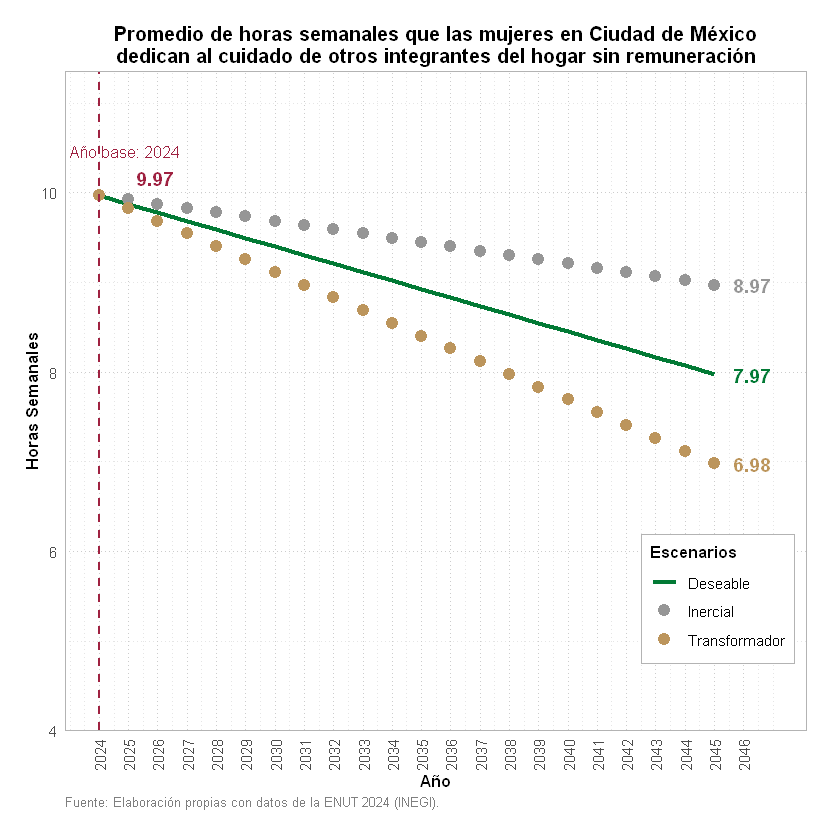

In [198]:

p_horas <- ggplot() +
  
  # Deseable: Línea continua (geom_line)
  geom_line(data = df_proyeccion_horas, aes(x = ciclo, y = Deseable, color = "Deseable"), linewidth = 1.25) +
  
  # Inercial: Puntos (geom_point)
  geom_point(data = df_proyeccion_horas, aes(x = ciclo, y = Inercial, color = "Inercial"), size = 3) +
  
  # Transformador: Puntos (geom_point)
  geom_point(data = df_proyeccion_horas, aes(x = ciclo, y = Transformador, color = "Transformador"), size = 3) +
  
  # Línea vertical del año base
  geom_vline(xintercept = ano_base, color = "#9F2241", linetype = "dashed", linewidth = 0.7) +
  annotate("text", x = ano_base + 0.9, y = max(df_proyeccion_horas$Inercial) * 1.05,
           label = paste("Año base:", ano_base),
           color = "#9F2241", size = 3.3, family = "roboto") +
  
  # Etiqueta base (Usamos el valor_base)
  annotate("text", x = ano_base + 1.9, y = valor_base + 0.2, 
           label = sprintf("%.2f", valor_base),
           color = "#9F2241", size = 4, fontface = "bold", family = "roboto") +
  
  # Etiquetas finales flotantes (Para el año 2045)
  annotate("text", x = 2046.3, y = df_proyeccion_horas$Deseable[df_proyeccion_horas$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_horas$Deseable[df_proyeccion_horas$ciclo == 2045]),
           color = "#027a35", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_proyeccion_horas$Inercial[df_proyeccion_horas$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_horas$Inercial[df_proyeccion_horas$ciclo == 2045]),
           color = "#969696", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_proyeccion_horas$Transformador[df_proyeccion_horas$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_horas$Transformador[df_proyeccion_horas$ciclo == 2045]),
           color = "#BC955C", size = 4, fontface = "bold", family = "roboto") +
  
  # Títulos y ejes 
  labs(
    title = "Promedio de horas semanales que las mujeres en Ciudad de México\ndedican al cuidado de otros integrantes del hogar sin remuneración",
    x = "Año",
    y = "Horas Semanales",
    color = "Escenarios",
    caption = "Fuente: Elaboración propias con datos de la ENUT 2024 (INEGI)."
  ) +
  
  # Escalas 
  scale_y_continuous(limits = c(4, 11), expand = expansion(mult = c(0, 0.05))) +
  scale_x_continuous(breaks = seq(ano_base, 2046, 1), limits = c(ano_base, 2047)) +
  
  # Colores (Se elimina "Observado") porque no tiene histórico
  scale_color_manual(values = c(
    "Deseable" = "#027a35",
    "Inercial" = "#969696",
    "Transformador" = "#BC955C"
  )) +
  
  # Tema (Se mantiene tu estilo)
  theme_minimal(base_family = "roboto") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(size = 10, face = "bold"),
    axis.text = element_text(size = 9),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted", linewidth = 0.5),
    panel.grid.minor = element_line(color = "gray90", linetype = "dotted", linewidth = 0.3),
    plot.caption = element_text(hjust = 0, size = 8, color = "gray50"),
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.position = c(0.88, 0.20),
    legend.background = element_rect(fill = "white", color = "gray70", size = 0.3),
    legend.key = element_rect(fill = "white", color = NA),
    panel.border = element_rect(color = "gray70", fill = NA, linewidth = 0.5),
    plot.margin = margin(15, 20, 20, 15)
  )

print(p_horas)

#### Promedio de horas semanales que la Población Ocupada de la Ciudad de México dedica a trabajo de cuidados directos no remunerados a otros integrantes del hogar

In [146]:
## Categorías y sus variables que utilizaremos para identificar los trabajos de cuidado a otras personas

#Categoría 1: Cuidados directos no remunerados a personas con discapacidad o enfermedad
var_discap_enfer <- c('p6_16a_3_1', 'p6_16a_3_2', 'p6_16a_3_3', 'p6_16a_3_4')

#Categoría 2: Cuidados directos no remunerados a bebés, niñas o niños de 0 a 5 años
var_cuid_0_5 <- c('p6_16a_4_1', 'p6_16a_4_2', 'p6_16a_4_3', 'p6_16a_4_4')

#Categoría 3: Cuidados directos no remunerados a bebés, niñas o niños de personas de 6 a 59 años
var_cuid_6_59 <- c('p6_16a_5_1', 'p6_16a_5_2', 'p6_16a_5_3', 'p6_16a_5_4')

#Categoría 4: Cuidados directos no remunerados a personas de 60 años y más
var_cuid_60 <- c('p6_16a_6_1', 'p6_16a_6_2', 'p6_16a_6_3', 'p6_16a_6_4')

In [147]:
#Horas totales en la semana de cuidados (repetido para la siguiente sección, se mantiene por estructura original)
tiempo_cuidados <- enut24 %>%
filter(p6_16_3 == 1 | p6_16_4 == 1 | p6_16_5 == 1 | p6_16_6 == 1) %>%
mutate(tiempo_discap  = (p6_16a_3_1 + p6_16a_3_2/60) + (p6_16a_3_3 + p6_16a_3_4/60),
       tiempo_0_5     = (p6_16a_4_1 + p6_16a_4_2/60) + (p6_16a_4_3 + p6_16a_4_4/60),
       tiempo_6_59    = (p6_16a_5_1 + p6_16a_5_2/60) + (p6_16a_5_3 + p6_16a_5_4/60),
       tiempo_60mas   = (p6_16a_6_1 + p6_16a_6_2/60) + (p6_16a_6_3 + p6_16a_6_4/60),
       tiempo_total_cuidados = rowSums(across(c(tiempo_discap, tiempo_0_5, tiempo_6_59, tiempo_60mas)), na.rm = TRUE))

head(tiempo_cuidados)

llavemod,llaveviv,llavehog,sexo,edad_v,p4_1,p4_1c,niv_x,gra_x,p4_3,⋯,upm_dis_y,control_y,viv_sel_y,hogar_y,n_ren_y,tiempo_discap,tiempo_0_5,tiempo_6_59,tiempo_60mas,tiempo_total_cuidados
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
90002903101,90002903,900029031,1,46,2,NA,8,3,NA,⋯,1148,900029,3,1,1,NA,NA,1,NA,1
90018104102,90018104,900181041,2,69,2,NA,3,3,NA,⋯,1149,900181,4,1,2,NA,4,NA,NA,4
90018301101,90018301,900183011,2,53,2,NA,8,4,NA,⋯,1150,900183,1,1,1,3,NA,NA,NA,3
90018301103,90018301,900183011,2,51,2,NA,8,4,NA,⋯,1150,900183,1,1,3,3,NA,NA,NA,3
90027001101,90027001,900270011,1,71,2,NA,3,3,NA,⋯,1152,900270,1,1,1,5,NA,NA,NA,5
90027001102,90027001,900270011,2,68,2,NA,3,3,NA,⋯,1152,900270,1,1,2,4,NA,NA,NA,4


In [148]:
#Cambio de variables a numéricas para tiempo de trabajo
variables_interes <- c("p5_1", "p5_2", "p5_8_1_1", "p5_8_1_2", "p5_8_1_3", "p5_8_1_4",
             "p5_8_2_1", "p5_8_2_2", "p5_8_2_3", "p5_8_2_4",
             "p5_9_1", "p5_9_2", "p5_9_3", "p5_9_4")

# Convertir las variables a numéricas
enut24[variables_interes] <- lapply(enut24[variables_interes], function(x) as.numeric(as.character(x)))

#Trabajo presencial
trab_presencial <- c('p5_8_1_1', 'p5_8_1_2', 'p5_8_1_3', 'p5_8_1_4')

#Trabajo remoto
trab_remoto <- c('p5_8_2_1', 'p5_8_2_2', 'p5_8_2_3', 'p5_8_2_4')

#Tiempo de traslado al trabajo
tiempo_tras <- c('p5_9_1', 'p5_9_2', 'p5_9_3', 'p5_9_4')

activ_trabajo <- c(1, 2, 3, 4, 5, 6, 7)

In [149]:
#Pob que hicieron trabajo para el mercado
ocupados <- enut24 %>%
filter(!is.na(p5_1), p5_1 == 1 |
         !is.na(p5_2), p5_2 %in% activ_trabajo) %>% #población ocupada
mutate(
    tiempo_trab_pres = (p5_8_1_1 + p5_8_1_2/60) + (p5_8_1_3 + p5_8_1_4/60),
    tiempo_trab_rem  = (p5_8_2_1 + p5_8_2_2/60) + (p5_8_2_3 + p5_8_2_4/60),
    tiempo_traslado  = (p5_9_1 + p5_9_2/60) + (p5_9_3 + p5_9_4/60),
    tiempo_trab_remun = rowSums(across(c(tiempo_trab_pres, tiempo_trab_rem, tiempo_traslado)), na.rm = TRUE))

head(ocupados)

llavemod,llaveviv,llavehog,sexo,edad_v,p4_1,p4_1c,niv_x,gra_x,p4_3,⋯,est_dis_y,upm_dis_y,control_y,viv_sel_y,hogar_y,n_ren_y,tiempo_trab_pres,tiempo_trab_rem,tiempo_traslado,tiempo_trab_remun
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
90002905104,90002905,900029051,1,20,2,NA,6,3,NA,⋯,73,1148,900029,5,1,4,6,NA,2.0000000,8.00000
90018304101,90018304,900183041,2,79,2,NA,2,6,1,⋯,74,1150,900183,4,1,1,16,NA,0.3333333,16.33333
90044302101,90044302,900443021,2,51,2,NA,7,3,NA,⋯,74,1153,900443,2,1,1,NA,NA,NA,0.00000
90088605103,90088605,900886051,1,19,2,NA,8,1,NA,⋯,74,1158,900886,5,1,3,16,NA,4.0000000,20.00000
90253501104,90253501,902535011,1,28,2,NA,6,3,NA,⋯,74,1170,902535,1,1,4,NA,NA,NA,0.00000
90258003101,90258003,902580031,2,98,2,NA,6,3,NA,⋯,73,1171,902580,3,1,1,NA,NA,NA,0.00000


In [150]:
ocupados_cuidados <- ocupados %>%
  left_join(
    tiempo_cuidados %>% 
      select(llavemod, llaveviv, llavehog, sexo, tiempo_total_cuidados),
    by = c("llavemod", "llaveviv", "llavehog", "sexo")
  )

In [151]:
head(ocupados_cuidados %>% 
select(llavemod, sexo, tiempo_trab_remun, tiempo_total_cuidados))

llavemod,sexo,tiempo_trab_remun,tiempo_total_cuidados
<dbl>,<dbl>,<dbl>,<dbl>
90002905104,1,8.00000,NA
90018304101,2,16.33333,NA
90044302101,2,0.00000,NA
90088605103,1,20.00000,NA
90253501104,1,0.00000,NA
90258003101,2,0.00000,8


In [152]:
resumen_ocupados <- ocupados_cuidados %>%
  summarise(promedio_cuidados   = weighted.mean(tiempo_total_cuidados, fac_per, na.rm = TRUE)) %>%
    pull(promedio_cuidados)

resumen_ocupados

[1] 17.98805

Proyecciones

In [156]:
# Definición de Valores Base y Metas
ano_base <- 2024 
valor_base_ocupados <- 17.9880477764813 # Valor promedio de horas en 2024 (TU VALOR BASE)

# Metas finales (2045) basadas en reducción porcentual
meta_transformador_2045_Ocupados <- valor_base_ocupados * 0.55 # 45% reducción
meta_deseable_2045_Ocupados      <- valor_base_ocupados * 0.70 # 30% reducción
meta_inercial_2045_Ocupados      <- valor_base_ocupados * 0.85 # 15% reducción

n_periodos_final <- 2045 - ano_base # 21 períodos

tasa_transformador_Ocupados <- (meta_transformador_2045_Ocupados / valor_base_ocupados)^(1 / n_periodos_final) - 1
tasa_deseable_Ocupados      <- (meta_deseable_2045_Ocupados / valor_base_ocupados)^(1 / n_periodos_final) - 1
tasa_inercial_Ocupados      <- (meta_inercial_2045_Ocupados / valor_base_ocupados)^(1 / n_periodos_final) - 1

# Construcción de la Serie de Proyección Anual
fut_years <- seq(ano_base, 2045, by = 1)
n_periodos <- fut_years - ano_base 

df_proyeccion_ocupados <- data.frame(
  ciclo = fut_years,
  # Proyección Compuesta: Valor Base * (1 + Tasa)^n_periodos
  Transformador = valor_base_ocupados * ((1 + tasa_transformador_Ocupados) ^ n_periodos),
  Deseable      = valor_base_ocupados * ((1 + tasa_deseable_Ocupados) ^ n_periodos),
  Inercial      = valor_base_ocupados * ((1 + tasa_inercial_Ocupados) ^ n_periodos)
)

cols_to_round <- c("Transformador", "Deseable", "Inercial") 
df_proyeccion_ocupados[, cols_to_round] <- round(df_proyeccion_ocupados[, cols_to_round], 6)

# Crear el objeto 'fut_ocupados'
fut_ocupados <- df_proyeccion_ocupados

message("Dataframe de proyecciones anuales de Horas de Cuidado (Población Ocupada):")
print(df_proyeccion_ocupados %>% filter(ciclo %in% c(2024, 2030, 2035, 2045)))
message("El objeto 'df_proyeccion_ocupados' y 'fut_ocupados' están listos.")

Dataframe de proyecciones anuales de Horas de Cuidado (Población Ocupada):



  ciclo Transformador Deseable Inercial
1  2024     17.988048 17.98805 17.98805
2  2030     15.163587 16.24525 17.17189
3  2035     13.151750 14.92261 16.52011
4  2045      9.893426 12.59163 15.28984


El objeto 'df_proyeccion_ocupados' y 'fut_ocupados' están listos.



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"

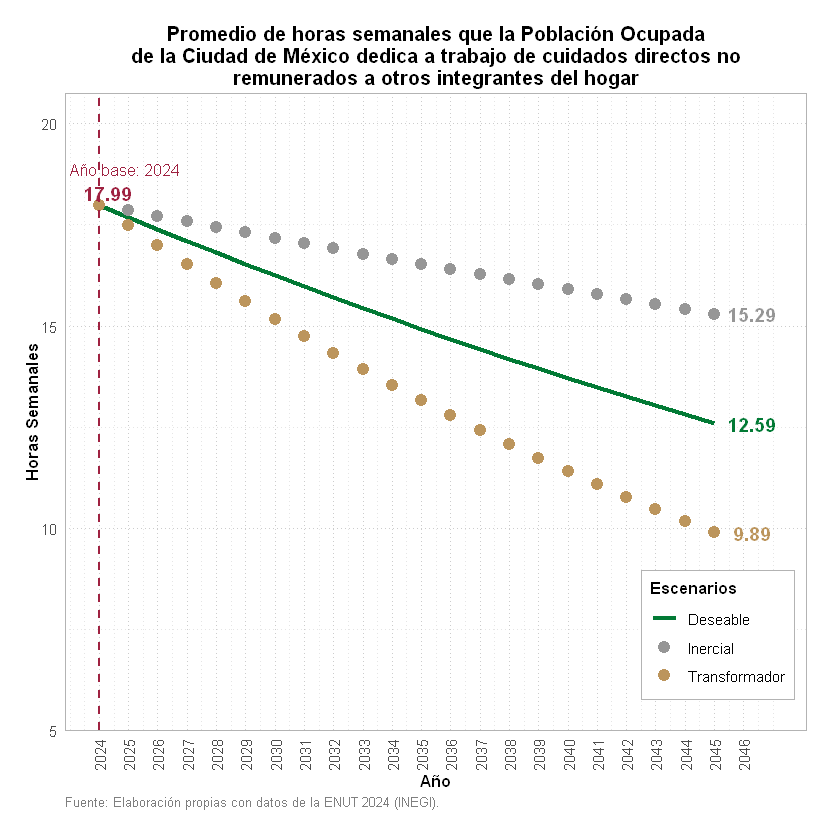

In [168]:
# Definir el valor base para las etiquetas
valor_base_grafica <- valor_base_ocupados

p_ocupados <- ggplot() +
  
  # Deseable: Línea continua 
  geom_line(data = df_proyeccion_ocupados, aes(x = ciclo, y = Deseable, color = "Deseable"), linewidth = 1.25) +
  
  # Inercial: Puntos
  geom_point(data = df_proyeccion_ocupados, aes(x = ciclo, y = Inercial, color = "Inercial"), size = 3) +
  
  # Transformador: Puntos 
  geom_point(data = df_proyeccion_ocupados, aes(x = ciclo, y = Transformador, color = "Transformador"), size = 3) +
  
  # Línea vertical del año base
  geom_vline(xintercept = ano_base, color = "#9F2241", linetype = "dashed", linewidth = 0.7) +
  annotate("text", x = ano_base + 0.9, y = max(df_proyeccion_ocupados$Inercial) * 1.05,
           label = paste("Año base:", ano_base),
           color = "#9F2241", size = 3.3, family = "roboto") +
  
  # Etiqueta base 
  annotate("text", x = ano_base + 0.3, y = valor_base_grafica + 0.3, 
           label = sprintf("%.2f", valor_base_grafica),
           color = "#9F2241", size = 4, fontface = "bold", family = "roboto") +
  
  # Etiquetas finales flotantes (Para el año 2045)
  annotate("text", x = 2046.3, y = df_proyeccion_ocupados$Deseable[df_proyeccion_ocupados$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_ocupados$Deseable[df_proyeccion_ocupados$ciclo == 2045]),
           color = "#027a35", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_proyeccion_ocupados$Inercial[df_proyeccion_ocupados$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_ocupados$Inercial[df_proyeccion_ocupados$ciclo == 2045]),
           color = "#969696", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_proyeccion_ocupados$Transformador[df_proyeccion_ocupados$ciclo == 2045],
           label = sprintf("%.2f", df_proyeccion_ocupados$Transformador[df_proyeccion_ocupados$ciclo == 2045]),
           color = "#BC955C", size = 4, fontface = "bold", family = "roboto") +
  
  labs(
    title = "Promedio de horas semanales que la Población Ocupada\nde la Ciudad de México dedica a trabajo de cuidados directos no\nremunerados a otros integrantes del hogar",
    x = "Año",
    y = "Horas Semanales",
    color = "Escenarios",
    caption = "Fuente: Elaboración propias con datos de la ENUT 2024 (INEGI)."
  ) +
  
  # Escalas (Ajuste recomendado de límites para un rango de 9 a 18 horas)
  scale_y_continuous(limits = c(5, 20), expand = expansion(mult = c(0, 0.05))) +
  scale_x_continuous(breaks = seq(ano_base, 2046, 1), limits = c(ano_base, 2047)) +
  
  # Colores (Se elimina "Observado")
  scale_color_manual(values = c(
    "Deseable" = "#027a35",
    "Inercial" = "#969696",
    "Transformador" = "#BC955C"
  )) +
  
  # Tema (Se mantiene tu estilo)
  theme_minimal(base_family = "roboto") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(size = 10, face = "bold"),
    axis.text = element_text(size = 9),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted", linewidth = 0.5),
    panel.grid.minor = element_line(color = "gray90", linetype = "dotted", linewidth = 0.3),
    plot.caption = element_text(hjust = 0, size = 8, color = "gray50"),
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.position = c(0.88, 0.15),
    legend.background = element_rect(fill = "white", color = "gray70", size = 0.3),
    legend.key = element_rect(fill = "white", color = NA),
    panel.border = element_rect(color = "gray70", fill = NA, linewidth = 0.5),
    plot.margin = margin(15, 20, 20, 15)
  )

print(p_ocupados)


Carga de Datos ENIGH

In [169]:
# Consideraciones generales y creación de estructura de carpetas
dir.create('ENIGH/Microdatos', showWarnings = FALSE, recursive = TRUE)
dir.create('ENIGH/Resultados', showWarnings = FALSE, recursive = TRUE)
options(timeout = 600)

In [170]:
# Objetos que necesitamos para poder descargar
years <- c('2016', '2018', '2020', '2022', '2024')
tablas <- c('poblacion', 'viviendas', 'concentradohogar')
carpeta = 'ENIGH/Microdatos'

descargar_enigh <- function(years, tablas, carpeta) {
  
  url_basica <- 'https://www.inegi.org.mx/contenidos/programas/enigh/nc/'
  fin <- '_csv.zip'
  
  if (!dir.exists(carpeta)) dir.create(carpeta, recursive = TRUE)
  
  data_list <- list()
  
  for (year in years) {
    message(paste("Procesando año:", year))
    data_list[[year]] <- list()
    
    for (tabla in tablas) {
      
      csv_final <- file.path(carpeta, paste0(tabla, '_', year, '.csv'))
      
      if (!file.exists(csv_final)) {
        
        url <- paste0(url_basica, year, '/microdatos/enigh', year, '_ns_', tabla, fin)
        destfile <- tempfile(fileext = '.zip')
        
        # Uso de tryCatch para manejar errores de descarga (URLs a veces fallan)
        tryCatch({
          download.file(url, destfile = destfile, mode = 'wb')
        }, error = function(e) {
          warning(paste("No se pudo descargar la tabla", tabla, "para el año", year, ". URL:", url))
          return(NULL) # Salta esta iteración
        })
        
        # Si la descarga falló, pasa a la siguiente tabla/año
        if (!file.exists(destfile)) next 
        
        # Listar archivos dentro del ZIP
        zip_files <- unzip(destfile, list = TRUE)
        
        # Selecciona el primer archivo que termine en .csv
        archivo_csv <- zip_files$Name[grep('\\.csv$', zip_files$Name, ignore.case = TRUE)][1]
        
        # Extraer ese archivo
        unzip(destfile, files = archivo_csv, exdir = tempdir())
        
        # Renombrar al nombre esperado y mover a la carpeta final
        file.rename(
          from = file.path(tempdir(), archivo_csv),
          to = csv_final
        )
        
        file.remove(destfile)
      }
      
      # Leer y limpiar nombres
      data_list[[year]][[tabla]] <- read_csv(csv_final, show_col_types = FALSE) %>%
        clean_names()
    }
  }
  
  # Guardar lista para uso posterior
  saveRDS(data_list, file.path(carpeta, 'data_list.RDS'))
  
  return(data_list)
}

In [171]:
#LÓGICA DE CARGA INTELIGENTE: Lee RDS si existe, descarga si no
ruta_rds <- file.path(carpeta, 'data_list.RDS')

if (file.exists(ruta_rds)) {
  message("Cargando bases de ENIGH desde el archivo RDS preexistente...")
  data_list <- readRDS(ruta_rds)
} else {
  message("El archivo RDS no existe. Iniciando descarga y procesamiento de ENIGH (puede tardar varios minutos)...")
  data_list <- descargar_enigh(years, tablas, carpeta)
}

names(data_list$'2024')
str(data_list)

Cargando bases de ENIGH desde el archivo RDS preexistente...



[1] "poblacion"        "viviendas"        "concentradohogar"

List of 5
 $ 2016:List of 3
  ..$ poblacion       : spc_tbl_ [257,805 × 178] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
  .. ..$ folioviv  : chr [1:257805] "0100003801" "0100003801" "0100003802" "0100003802" ...
  .. ..$ foliohog  : num [1:257805] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ numren    : chr [1:257805] "01" "02" "01" "02" ...
  .. ..$ parentesco: num [1:257805] 101 201 101 201 101 201 301 301 301 301 ...
  .. ..$ sexo      : num [1:257805] 1 2 1 2 1 2 1 2 2 2 ...
  .. ..$ edad      : num [1:257805] 33 34 29 30 47 40 13 11 8 6 ...
  .. ..$ madre_hog : num [1:257805] 2 2 2 2 2 2 1 1 1 1 ...
  .. ..$ madre_id  : chr [1:257805] NA NA NA NA ...
  .. ..$ padre_hog : num [1:257805] 2 2 2 2 2 2 1 1 1 1 ...
  .. ..$ padre_id  : chr [1:257805] NA NA NA NA ...
  .. ..$ disc1     : num [1:257805] 8 8 8 8 8 8 8 8 8 8 ...
  .. ..$ disc2     : num [1:257805] NA NA NA NA NA NA NA NA NA NA ...
  .. ..$ disc3     : num [1:257805] NA NA NA NA NA NA NA NA NA NA ...
  .. ..$ disc4     : num [1:257805] NA 

#### Porcentaje de Mujeres en Edad de Trabajar de la Ciudad de México que se dedican a cuidados no remunerados de otras personas

In [172]:
calcular_cuidadoras <- function(anio) {
  # Extraer data frames de la lista principal
  poblacion <- data_list[[as.character(anio)]]$poblacion
  vivienda  <- data_list[[as.character(anio)]]$vivienda
  
  # Asegurar tipo character en folioviv
  poblacion <- poblacion %>%
    mutate(folioviv = as.character(folioviv))
  
  # Extraer entidad (dos primeros dígitos)
  poblacion <- poblacion %>%
    mutate(entidad = as.numeric(str_sub(folioviv, 1, 2)))
  
  # Seleccionar variables relevantes
  ubicacion <- vivienda %>%
    select(folioviv, ubica_geo, factor)
  
  pob <- poblacion %>%
    select(folioviv, edad, sexo, usotiempo4, hor_4, entidad)
  
  # Unir ambas bases
  tiempo <- ubicacion %>%
    left_join(pob, by = "folioviv")
  
  # Calcular totales
  total_mujeres <- tiempo %>%
    filter(sexo == 2, edad > 14, entidad == 9) %>%
    summarise(total_mujeres = sum(factor, na.rm = TRUE))
  
  tot_cuidadoras <- tiempo %>%
    filter(sexo == 2, hor_4 != 0, !is.na(hor_4), edad > 14, entidad == 9) %>%
    summarise(tot_Cuidadoras = sum(factor, na.rm = TRUE))
  
  # Crear resumen y añadir año
  resumen <- bind_cols(total_mujeres, tot_cuidadoras) %>%
    mutate(
      porcentaje_cuidadoras = 100 * tot_Cuidadoras / total_mujeres,
      anio = anio
    )
  
  return(resumen)
}

# Aplicar la función a todos los años disponibles en la lista
resumen_por_anio <- map_dfr(names(data_list), calcular_cuidadoras)

resumen_por_anio

total_mujeres,tot_Cuidadoras,porcentaje_cuidadoras,anio
<dbl>,<dbl>,<dbl>,<chr>
3990848,1126634,28.23044,2016
4038369,976417,24.17850,2018
4197906,842777,20.07613,2020
4286292,1004475,23.43459,2022
4334454,1018805,23.50481,2024


GRAFICO

In [173]:
resumen_por_anio <- resumen_por_anio %>%
  mutate(anio = as.numeric(anio)) %>%
  arrange(anio)

# Calcular delta anual compuesto
resumen_por_anio <- resumen_por_anio %>%
  mutate(valor_lag = lag(porcentaje_cuidadoras),
         anio_lag = lag(anio),
         delta = (porcentaje_cuidadoras / valor_lag)^(1 / (anio - anio_lag)) - 1)

# Tasa promedio histórica
delta_prom <- mean(resumen_por_anio$delta, na.rm = TRUE)

# Año base y valor base
ano_base <- 2024
valor_24 <- resumen_por_anio %>%
  filter(anio == ano_base) %>%
  pull(porcentaje_cuidadoras)

In [174]:
fut_years <- seq(ano_base, 2045, by = 1)
n_periodos <- fut_years - ano_base # Número de períodos desde el año base

# Crear el data frame de proyecciones anuales (df_future)
df_future <- data.frame(
  ciclo = fut_years,
  # Tasa de crecimiento: (1 + delta_prom/3) ^ n_periodos
  Inercial = valor_24 * ((1 + delta_prom / 3) ^ n_periodos), # ¡CORREGIDO!
  # Tasa de crecimiento: (1 + delta_prom/2) ^ n_periodos
  Deseable = valor_24 * ((1 + delta_prom / 2) ^ n_periodos),
  # Tasa de crecimiento: (1 + delta_prom) ^ n_periodos
  Transformador = valor_24 * ((1 + delta_prom) ^ n_periodos)
)

# Preparar la historia (del Primer Código, para la línea observada)
tabla_confianza <- resumen_por_anio %>%
  select(year = anio, porcentaje = porcentaje_cuidadoras) %>%
  mutate(year = as.numeric(year), porcentaje = as.numeric(porcentaje)) %>%
  arrange(year)

years_hist <- seq(min(tabla_confianza$year), ano_base, by = 1)
interp <- approx(x = tabla_confianza$year, y = tabla_confianza$porcentaje,
                 xout = years_hist, method = "linear", ties = mean)

hist_df <- data.frame(ciclo = interp$x, Deseable = round(interp$y, 2))
valor_base <- hist_df$Deseable[hist_df$ciclo == ano_base]

hist_no_base <- hist_df %>% 
  filter(ciclo < ano_base) %>%
  mutate(Inercial = NA_real_, Transformador = NA_real_) %>% # ¡CORREGIDO!
  select(ciclo, Deseable, Inercial, Transformador) # ¡CORREGIDO!

# Unir historia y proyecciones
df_final <- bind_rows(hist_no_base, df_future)

In [175]:
# Ajuste Final para el año base (Asegurar que sea el valor observado en todos)
df_final[df_final$ciclo == ano_base, "Deseable"] <- valor_base
df_final[df_final$ciclo == ano_base, "Inercial"] <- valor_base # ¡CORREGIDO!
df_final[df_final$ciclo == ano_base, "Transformador"] <- valor_base

# Redondear a 2 decimales
cols_to_round <- c("Deseable", "Inercial", "Transformador") # ¡CORREGIDO!
df_final[, cols_to_round] <- round(df_final[, cols_to_round], 2)


# Crear los objetos específicos para la visualización con ggplot2
obs <- df_final %>% 
  filter(ciclo <= ano_base) # Serie Observada/Histórica

fut <- df_final %>% 
  filter(ciclo >= ano_base) # Serie Futura/Proyectada

message("El objeto 'df_final' ahora contiene proyecciones anuales con la lógica de tasa compuesta y nombres corregidos.")
print(df_final)

message("El objeto 'df_final', 'obs', y 'fut' están listos para tu código de ggplot2.")

El objeto 'df_final' ahora contiene proyecciones anuales con la lógica de tasa compuesta y nombres corregidos.



   ciclo Deseable Inercial Transformador
1   2016    28.23       NA            NA
2   2017    26.20       NA            NA
3   2018    24.18       NA            NA
4   2019    22.13       NA            NA
5   2020    20.08       NA            NA
6   2021    21.76       NA            NA
7   2022    23.43       NA            NA
8   2023    23.47       NA            NA
9   2024    23.50    23.50         23.50
10  2025    23.27    23.35         23.03
11  2026    23.03    23.19         22.56
12  2027    22.79    23.03         22.10
13  2028    22.56    22.87         21.65
14  2029    22.33    22.72         21.21
15  2030    22.11    22.56         20.78
16  2031    21.88    22.41         20.35
17  2032    21.66    22.26         19.94
18  2033    21.44    22.11         19.53
19  2034    21.22    21.96         19.14
20  2035    21.00    21.81         18.75
21  2036    20.79    21.66         18.37
22  2037    20.58    21.51         17.99
23  2038    20.37    21.37         17.63
24  2039    20.1

El objeto 'df_final', 'obs', y 'fut' están listos para tu código de ggplot2.



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'roboto' not found in PostScript font database"

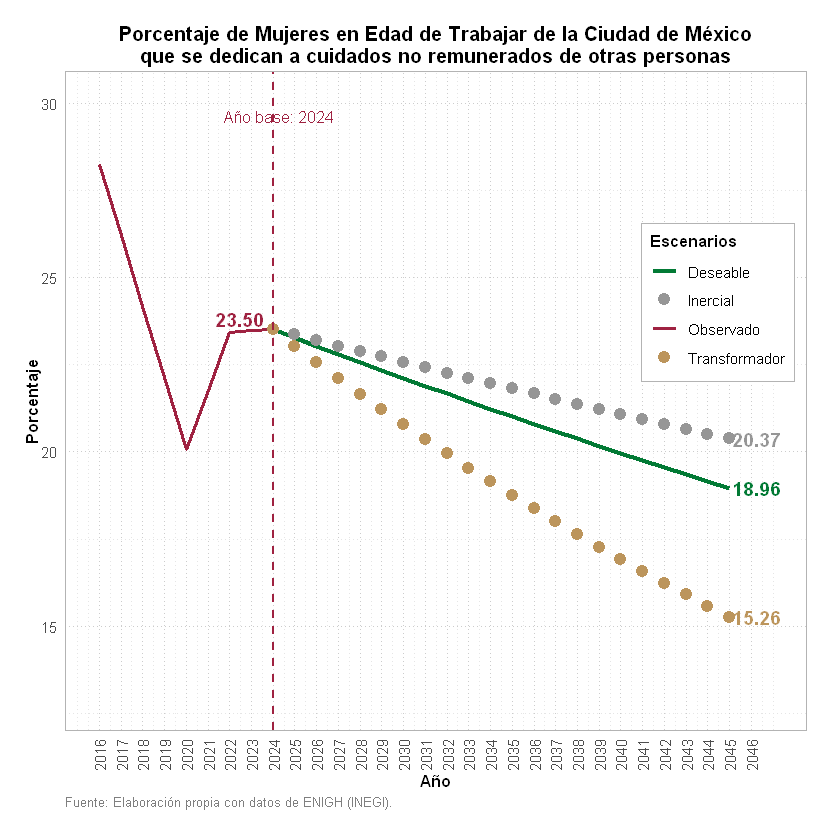

In [176]:
p <- ggplot() +
  
  # Observado
  geom_line(data = obs, aes(x = ciclo, y = Deseable, color = "Observado"), linewidth = 1.1) +
  
  # Deseable
  geom_line(data = fut, aes(x = ciclo, y = Deseable, color = "Deseable"), linewidth = 1.25) +
  
  # Escenarios futuros
  geom_point(data = fut, aes(x = ciclo, y = Inercial, color = "Inercial"), size = 3) +
  geom_point(data = fut, aes(x = ciclo, y = Transformador, color = "Transformador"), size = 3) +
  
  # Línea vertical del año base
  geom_vline(xintercept = ano_base, color = "#9F2241", linetype = "dashed", linewidth = 0.7) +
  annotate("text", x = ano_base + 0.3, y = max(df_final$Deseable) * 1.05,
           label = paste("Año base:", ano_base),
           color = "#9F2241", size = 3.3, family = "roboto") +
  
  # Etiqueta base
  annotate("text", x = ano_base - 1.5, y = df_final$Deseable[df_final$ciclo == ano_base]+0.3,
           label = sprintf("%.2f", df_final$Deseable[df_final$ciclo == ano_base]),
           color = "#9F2241", size = 4, fontface = "bold", family = "roboto") +
  
  # Etiquetas finales flotantes (🔹 ahora con dos decimales)
  annotate("text", x = 2046.3, y = df_final$Deseable[df_final$ciclo == 2045],
           label = sprintf("%.2f", df_final$Deseable[df_final$ciclo == 2045]),
           color = "#027a35", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_final$Inercial[df_final$ciclo == 2045],
           label = sprintf("%.2f", df_final$Inercial[df_final$ciclo == 2045]),
           color = "#969696", size = 4, fontface = "bold", family = "roboto") +
  annotate("text", x = 2046.3, y = df_final$Transformador[df_final$ciclo == 2045],
           label = sprintf("%.2f", df_final$Transformador[df_final$ciclo == 2045]),
           color = "#BC955C", size = 4, fontface = "bold", family = "roboto") +
  
  # Títulos y ejes
  labs(
    title = "Porcentaje de Mujeres en Edad de Trabajar de la Ciudad de México\nque se dedican a cuidados no remunerados de otras personas",
    x = "Año",
    y = "Porcentaje",
    color = "Escenarios",
    caption = "Fuente: Elaboración propia con datos de ENIGH (INEGI)."
  ) +
  
  # Escalas
  scale_y_continuous(limits = c(12, 30), expand = expansion(mult = c(0, 0.05))) +
  scale_x_continuous(breaks = seq(2016, 2046, 1), limits = c(2016, 2047)) +
  
  # Colores
  scale_color_manual(values = c(
    "Observado" = "#9F2241",
    "Deseable" = "#027a35",
    "Inercial" = "#969696",
    "Transformador" = "#BC955C"
  )) +
  
  # Tema con cuadrícula más visible
  theme_minimal(base_family = "roboto") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(size = 10, face = "bold"),
    axis.text = element_text(size = 9),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted", linewidth = 0.5),
    panel.grid.minor = element_line(color = "gray90", linetype = "dotted", linewidth = 0.3),
    plot.caption = element_text(hjust = 0, size = 8, color = "gray50"),
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.position = c(0.88, 0.65),
    legend.background = element_rect(fill = "white", color = "gray70", size = 0.3),
    legend.key = element_rect(fill = "white", color = NA),
    panel.border = element_rect(color = "gray70", fill = NA, linewidth = 0.5),
    plot.margin = margin(15, 20, 20, 15)
  )

print(p)
